# 27Al CQ prediction with SOAP features

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure as ST
from src.soap_utilities import getXY, get_species
import copy

In [2]:
# Read processed data and continue
with open("./data/processed_data_0.5.json", "r") as file:
    data_reload = json.load(file)
for data in data_reload:
    data['structure'] = ST.from_dict(data['structure'])
print("length of data set is:", len(data_reload))

length of data set is: 1681


In [4]:
# Atom Species
species = get_species(data_reload)
print("num of species in the data set:",len(species))

num of species in the data set: 76


In [ ]:
X,y,loc = getXY(data_reload,species)
print(X.shape,y.shape)

In [8]:
from sklearn.decomposition import TruncatedSVD
N = 100
pca = TruncatedSVD(n_components=N,algorithm="arpack")
X_pca_fit = pca.fit(X)
X_pca = X_pca_fit.transform(X)

print(f"PCA covers {sum(X_pca_fit.explained_variance_ratio_)}% of variance")
print (f'PCA done! New shape {X_pca.shape}')

PCA covers 0.9822579904042779% of variance
PCA done! New shape (8081, 100)


In [9]:
# Get absolute value of CQ
y['nmr'] = abs(y['nmr'])

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2,random_state=20)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(6464, 100) (6464, 3) (1617, 100) (1617, 3)


In [10]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10,min_samples_split=4,min_samples_leaf=2)

param = {"n_estimators": randint(low=100, high=500), 
         "max_depth": uniform(10, 200),
         "max_features": ['auto', 'sqrt','log2']
         }

grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)

grid.fit(X_train, y_train['nmr'])

# summarize the results of the grid search
train_r2 = np.sort(grid.cv_results_['mean_test_r2'])[-1]
train_RMSE = math.sqrt(-np.sort(grid.cv_results_['mean_test_neg_mean_squared_error'])[-1])
train_MAE = -np.sort(grid.cv_results_['mean_test_neg_mean_absolute_error'])[-1]

print('training score: R2 = {}, RMSE = {}, MAE = {}'.format(train_r2, train_RMSE, train_MAE))
print(grid.best_estimator_)

training score: R2 = 0.8846509390798813, RMSE = 1.3793093232480191, MAE = 0.6161895911102637
RandomForestRegressor(max_depth=148.35416647251827, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=168, random_state=10)
CPU times: user 1min, sys: 414 ms, total: 1min
Wall time: 3min 36s


test scores: R2 = 0.9244570871685841, RMSE = 1.0691768338640482, MAE = 0.43052545531412184
date and time: 03-12-2021_16-08-27


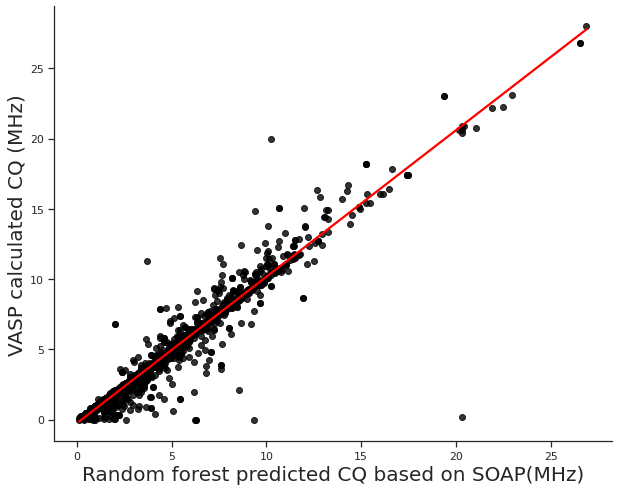

CPU times: user 9.43 s, sys: 151 ms, total: 9.58 s
Wall time: 9.52 s


In [12]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set()

y_rf = grid.predict(X_test)

test_r2 = r2_score(y_test['nmr'], y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test['nmr'], y_rf))
test_MAE = mean_absolute_error(y_test['nmr'], y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test['nmr']
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

#plot the correlation
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)
ax.set_xlabel("Random forest predicted CQ based on SOAP(MHz)",fontsize=20)
ax.set_ylabel("VASP calculated CQ (MHz)",fontsize=20)
sns.despine()
plt.show()

# Export y_rf and y_test as .csv
y_output = copy.deepcopy(y_test)
y_output['CQ_rf'] = y_rf
y_output = pd.DataFrame(y_output)
y_output.to_csv('./data/SOAP_test.csv')